## How to use this script

Run all the cells before Section "Experiment 2". From there, you can run one of the following experiments independently:

- (**Exp 1** - Willmore validation : not here but in the other notebook)
- **Exp 2** - Generates a single shape (and shows how to track the convergence)
- **Exp 3** - Bilinear interpolation
- **Exp 4** - Generate random shapes and plot them in UMAP

The notebook also contains a few extensions:

- **Ext 1** - Orientation
- **Ext 2** - Spatialization

For more details, please refer to my paper [here](https://arxiv.org/abs/2103.04856)!

**If you find any problem in this script**, please contact me at a.song19@imperial.ac.uk.
Good luck for generating beautiful shapes! If you get interesting shapes that have not been featured
in the paper and want to show them to me, I will be happy to discuss about it.

In [1]:
!pip3 install torch torchvision torchaudio

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [7]:
# THIS HAS TO BE AT THE TOP OF EVERY JUPYTER NOTEBOOK TO AUTOMATICALLY RELOAD CODE CHANGES ON THE FILE SYSTEM.
%load_ext autoreload
%autoreload 2


In [2]:
import os
!pip install nibabel
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import string
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
def formatted(f): return format(f, '.3f').rstrip('0').rstrip('.')

import torch
dtype = torch.cuda.FloatTensor # we work with GPUs # if torch.cuda.is_available() else torch.FloatTensor

# curvatubes imports
from cvtub.utils import slices, single, load_nii, save_nii, random_init, init_balls
from cvtub.energy import discrepancy, ratio_discr


/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# Main generator function

In [3]:
# Main function that generates 3D shapes with curvatubes

# optimizer: Adam
# flow type: conservative H^{-1}
# periodic boundary conditions


from cvtub.generator import _generate_shape

def generate(A0, params, M0, delta_x, maxeval = 10000, snapshot_folder = '', exp_title = '',
             display_all = True, check_viable = False, cond_take_snapshot = None) :  
    
    '''Optimizes the phase-field Feps(u) ( see paper / see comments in cvtub/energy.py ) '''
    
    xi =  1e-6
    flow_type = 'cons'
    mode = 'periodic'
    optim_method = 'adam'
    sigma_blur = 2
    Z,X,Y = A0[0].shape

    optim_props = {'maxeval': maxeval, 'sigma_blur': sigma_blur, 'lr': .001, 'eps_adam' : 1e-2, 
                   'betas' : (0.9,0.999), 'weight_decay' : 0, 'amsgrad' : False,
                   'display_it_nb' : 1000, 'fill_curve_nb' : 50}
    
    u = _generate_shape(A0, params, delta_x, xi, optim_method, optim_props, flow_type, mode,
                               M0 = M0, snapshot_folder = snapshot_folder, exp_title = exp_title, 
                                cond_take_snapshot = cond_take_snapshot, display_all = display_all, 
                                check_viable = check_viable)
    
    if check_viable == True :
        u, viable_bool = u
        return u.detach().cpu().numpy(), viable_bool

    return u.detach().cpu().numpy()


In [4]:
# Function which plots the curvature diagram of a shape 
# defined as the zero level set of a phase-field u

from cvtub.curvdiags import kap_eps, curvhist, density_scatter

def plot_curvature_diagram(u, save = True, save_name = 'curvature_diagram.png'):

    kap1_eps, kap2_eps = kap_eps(u)

    kap1_vals, kap2_vals, areas = \
    curvhist(u, kap1_eps, kap2_eps, delta_x = 0.01, show_figs = False)

    x,y = np.clip(kap1_vals, -100,100), np.clip(kap2_vals, -100, 100)
    density_scatter(x,y, areas, showid = True, equalaxis = True, 
                    bins = 100, xlabel = 'kap1', 
                    ylabel = 'kap2', save = save, save_name = save_name)


### You can stop here, and then run individual experiments.

# Experiment 2 - Generate a single shape

**Generate** shapes with `generate()`.

We work with a vector field A instead of the scalar field u itself, because the $H^{-1}$ flow in u
translates into a $L^2$ flow in A (see the paper). The main parameters are

- ```params = eps, a20, a11, a02, b10, b01, c```, where
    - `eps` is the **phase-transition parameter**
    - `a20, a11, a02, b10, b01, c` are the **polynomial coefficients** in the curvature functional


- the **mass** `M0`, which is the imposed average of the phase-field *u*
- `MAXEVAL`, the nb of iterations of the algorithm. In the paper, I chose 8000 to be very secure, but you can actually take 4000 (sufficient) or even 1000 (approximate shape).

> *Remarks*:
> - in the paper, the term "generation parameters" refers to the tuple `(a20, a11, a02, b10, b01, c, M0)`
> -  to include orientation, or use spatialized parameters, see **Ext 1** and **Ext 2**.

**Visualize its curvature diagram** with `plot_curvature_diagram()`.

You can plot the curvature diagrams, i.e., the histograms of the diffuse principal curvatures `(kap1_eps, kap2_eps)`.

**Export the phase-field $u$** into `.nii.gz` format with `save_nii()`.

You can then visualize the level set $\{u = 0\}$ for instance in Paraview or 3DSlicer.\
You can also visualize $u$ or $\{u = 0\}$ in the notebook itself using [pyvista](https://docs.pyvista.org/).

In [5]:
# Create some folders to save the results

niifolder = '../results/Experiment_2/'
curvesfolder = niifolder + 'Curves/'
diagsfolder = niifolder + 'Diagrams/'

if not os.path.exists(niifolder):
    print(niifolder + ' folder does not exist, creating it...')
    os.makedirs(niifolder)
if not os.path.exists(curvesfolder):
    print('Curves subfolder does not exist, creating it...')
    os.makedirs(curvesfolder)
if not os.path.exists(diagsfolder):
    print('Diagrams subfolder does not exist, creating it...')
    os.makedirs(diagsfolder)

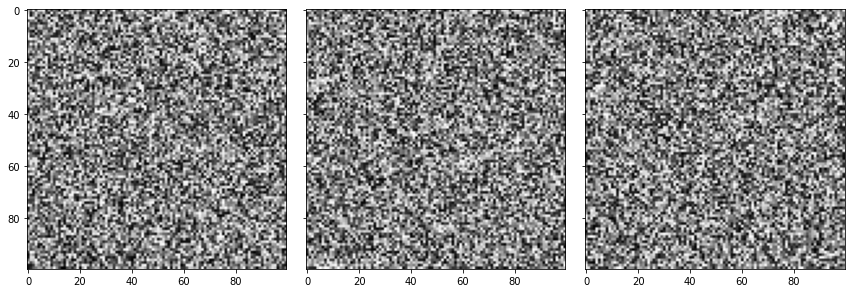

polykap_deg2 adam cons periodic
eps 0.02 coeffs [1, 0.85, 6, -80, -7.5, 1770] m -0.42
dx = 0.010, LZ = 1.00, LX = 1.000, LY = 1.000, xi = 1e-06
{'maxeval': 4000, 'sigma_blur': 2, 'lr': 0.001, 'eps_adam': 0.01, 'betas': (0.9, 0.999), 'weight_decay': 0, 'amsgrad': False, 'display_it_nb': 1000, 'fill_curve_nb': 50}

 umin = -2.1122984886169434, umax = 1.1869474649429321
 m =  -0.420 

E = 316823.1875

  100: E = 6.92e+03,  umin = -0.9418076872825623, umax = 0.7475435733795166


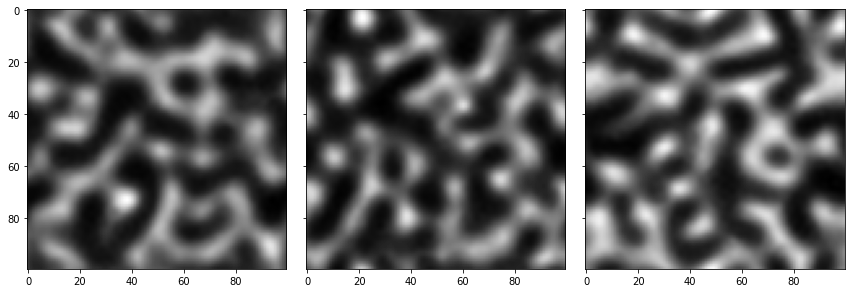


  200: E = 4.13e+03, 
  300: E = 3.27e+03,  umin = -0.9526533484458923, umax = 0.629210889339447


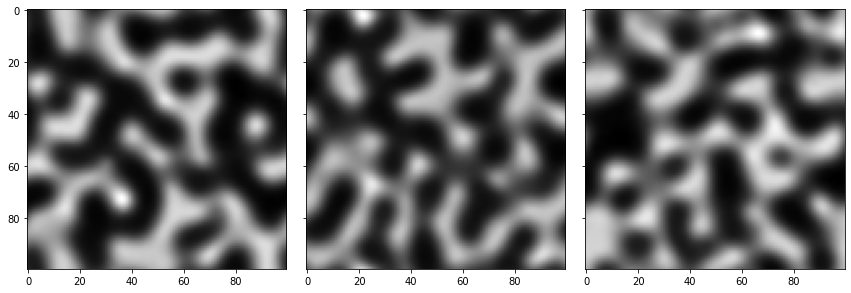

In [ ]:
# Number of iterations?
MAXEVAL = 4000 
# 4000 are generally sufficient, 8000 are over-sufficient

# Sizes
Z,X,Y = 100,100,100
delta_x = 1/100

# Initialize A = A0: a random vector field with values in R^3
A0 = 40 * delta_x * np.random.rand(3,Z,X,Y)
A0 = torch.Tensor(A0)#.type(dtype)
slices(A0[0]) # show three 2D slices of the 3D scalar field A0[0] 

# Parameters
eps = 0.02
a20, a11, a02, b10, b01, c = 1, 0.85, 6, -80, -7.5, 1770
M0 = -0.42
params = eps, a20, a11, a02, b10, b01, c

# Generate the shape - you will see slices of u along the iterations, and the loss curves are saved in their folder
u = generate(A0, params, M0, delta_x, maxeval = MAXEVAL, snapshot_folder = niifolder)

In [ ]:

# Save u as a .nii.gz file
str_tup = tuple([ formatted(x) for x in [eps, a20, a11, a02, b10, b01, c, M0]])
name = 'eps {} coeffs [{}, {}, {}, {}, {}, {}] m {}'.format(*str_tup)
print(name)
save_nii(np.floor(100 * u) / 100, niifolder + name) # or u if you have more space

# Plot and save its curvature diagram
plot_curvature_diagram(u, save = True, save_name = diagsfolder + name + ' kap1_kap2.png')

## How to keep track of the convergence

In [ ]:
# Define at which iterations you want to save the current u as a .nii.gz file

def cond_take_snapshot(iteration):
    if iteration in [10, 100, 200, 400, 1000, 2000, 4000] :
        return True

u, A = generate(A0, params, M0, delta_x, maxeval = 4001, snapshot_folder = niifolder, cond_take_snapshot = cond_take_snapshot)

# Experiment 3 - Bilinear interpolation

In [ ]:
# Create some folders to save the results

niifolder = '../results/Experiment_3/'
curvesfolder = niifolder + 'Curves/'
diagsfolder = niifolder + 'Diagrams/'

if not os.path.exists(niifolder):
    print(niifolder + ' folder does not exist, creating it...')
    os.makedirs(niifolder)
if not os.path.exists(curvesfolder):
    print('Curves subfolder does not exist, creating it...')
    os.makedirs(curvesfolder)
if not os.path.exists(diagsfolder):
    print('Diagrams subfolder does not exist, creating it...')
    os.makedirs(diagsfolder)

In [ ]:
# Bilinear interpolation between the generation parameters of
# 4 ref shape textures: layers, spheres, tubes, sponges
# All simulations start from the same A0

from cvtub.utils import convert_params
    
# nb of iterations in the algorithm
MAXEVAL = 4000 # 8000 in the paper

# sizes
Z,X,Y = 100,100,100
eps = 0.02
delta_x = 1/100

# layers
M0 = -0.3
h2,H0,k1,s,kap1_0,t,kap2_0 = 1,0,0,1,0,1,0
a20, a11, a02, b10, b01, c = convert_params(h2,H0,k1,s,kap1_0,t,kap2_0)
pm_layers = eps, a20, a11, a02, b10, b01, c, M0

# spheres
M0 = -0.6
R = 0.08
h2,H0,k1,s,kap1_0,t,kap2_0 = 1,2/R,0,1,1/R,1,1/R
a20, a11, a02, b10, b01, c = convert_params(h2,H0,k1,s,kap1_0,t,kap2_0)
pm_spheres = eps, a20, a11, a02, b10, b01, c, M0

# tubes
M0 = -0.7
r = 0.04
h2,H0,k1,s,kap1_0,t,kap2_0 = 1,1/r,0,1,1/r,10,0
a20, a11, a02, b10, b01, c = convert_params(h2,H0,k1,s,kap1_0,t,kap2_0)
pm_tubes = eps, a20, a11, a02, b10, b01, c, M0

# sponges
M0 = -0.25
h2,H0,k1,s,kap1_0,t,kap2_0 = 1,5,0.8,0,0,1,0
a20, a11, a02, b10, b01, c = convert_params(h2,H0,k1,s,kap1_0,t,kap2_0)
pm_sponges = eps, a20, a11, a02, b10, b01, c, M0

surnames = ['layers','spheres','tubes','sponges']
pms = [pm_layers, pm_spheres, pm_tubes, pm_sponges]

for i in range(4) :
    print(surnames[i])
    print(pms[i])
    
x1, x2 = 0, 1
y1, y2 = 0, 1

n = 4 # nb of intervals between endpoints (n = 4 in the paper)

q11 = np.array(pm_layers)[None,None,:]
q12 = np.array(pm_spheres)[None,None,:]
q22 = np.array(pm_tubes)[None,None,:]
q21 = np.array(pm_sponges)[None,None,:]

x,y = np.mgrid[0:1:(n+1)*1j, 0:1:(n+1)*1j] # is,js convention
x = x[:,:,None] 
y = y[:,:,None]

# bilinear interpolation of the parameters (eps, [coeffs], M0)
pms_interp = ( q11 * (x2 - x) * (y2 - y) + q21 * (x - x1) * (y2 - y) + q12 * (x2 - x) * (y - y1) + q22 * (x - x1) * (y - y1) ) / ((x2 - x1) * (y2 - y1))


In [ ]:
# Initialize A0 (the same for all)

A0 = 40 * delta_x * np.random.rand(3,Z,X,Y) # 20 or 40 * delta_x * ...
A0 = torch.Tensor(A0).type(dtype)

# Generate bilinear interpolation now!

for i in range(n+1) :
    for j in range(n+1) :
        
        # Specify and save parameter values
        params = pms_interp[i,j,:-1]
        M0 = pms_interp[i,j,-1]
        a20, a11, a02, b10, b01, c = params[1:7]
        
        print('I,J = {},{}'.format(i,j))
        print('Coeffs {} '.format(params[1:7]))
        print('Mass {} '.format(M0))

        file_object = open(niifolder + 'meta.txt', 'a')
        file_object.write('I,J = {},{} \n'.format(i,j))
        file_object.write('eps {} \n'.format(eps))
        file_object.close()

        u = generate(A0, params, M0, delta_x, maxeval = MAXEVAL, snapshot_folder = niifolder, exp_title = 'I {} J {} '.format(i,j))

        str_tup = tuple([ formatted(x) for x in [a20, a11, a02, b10, b01, c, M0]])
        name = 'I {} J {} coeffs [{} {} {} {} {} {}] m {}'.format(i,j,*str_tup)
        print(name)
        
        # Save u as a .nii.gz file
        save_nii(np.floor(100 * u) / 100, niifolder + name) # or u, if you have more space

        # Plot and save its curvature diagram
        plot_curvature_diagram(u, save = True, save_name = diagsfolder + name + ' kap1_kap2.png')

        clear_output()
        torch.cuda.empty_cache()

# Experiment 4 - Generate random shapes and plot them in UMAP

In [ ]:
# Create some folders to save the results

niifolder = '../results/Experiment_4/'
curvesfolder = niifolder + 'Curves/'
diagsfolder = niifolder + 'Diagrams/'

if not os.path.exists(niifolder):
    print(niifolder + ' folder does not exist, creating it...')
    os.makedirs(niifolder)
if not os.path.exists(curvesfolder):
    print('Curves subfolder does not exist, creating it...')
    os.makedirs(curvesfolder)
if not os.path.exists(diagsfolder):
    print('Diagrams subfolder does not exist, creating it...')
    os.makedirs(diagsfolder)

In [ ]:
# Some functions to visualize the final plot...

import umap
import hdbscan
import matplotlib.colors as mcolors

def give_color_array(nb_clusters) : 
    # gives a collection of colors to make nice legends
    colors1 = plt.cm.tab20b(np.linspace(0., 1, 128))
    colors2 = plt.cm.tab20c(np.linspace(0, 1, 128))
    colors = np.vstack((colors1, colors2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
    cm = plt.get_cmap(mymap)
    colors = [cm(1.*i/nb_clusters) for i in range(nb_clusters)]
    return colors

def SCAN_cluster(umap_embedding) : # shape (nb of points, dimension) 
    clustering = hdbscan.HDBSCAN(
        min_samples = 10,
        min_cluster_size = 10)
    labels = clustering.fit_predict(umap_embedding)
    return labels

def scatter_atlas(points, labels, title_string = '', save = True, folder = '', 
                        size = 3, markerscale = 5) :
    L = len(points)
    unique_labels = np.unique(labels) # labels included between 0 and L-1
    colors = give_color_array(len(unique_labels))
        
    plt.figure(figsize=(12,12))
    ax = plt.gca()    

    for i,l in enumerate(unique_labels) :
        wh = np.where(labels == l)[0]
        col = np.repeat(np.array(colors[i])[None], len(wh), axis = 0)
        ax.scatter(points[wh,0], points[wh,1], s=size, c= col, label = l, edgecolors='none')

    ax.set_title(title_string, fontsize=20)
    ax.set_aspect('equal', adjustable='box')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.75, box.height]) # 0.75 good for 30 labels
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale = markerscale, prop = {'size':10})
    if save :
        plt.savefig(folder + title_string + '.png', dpi=200)
    plt.show()
    

In [ ]:
# We generate random shapes by choosing random coefficients and only keeping viable shapes.
# The pairwise Wasserstein distances are computed between all pairs of shapes with geomloss 
#                            https://www.kernel-operations.io/geomloss/
# and UMAP embeds the dataset into a 2D atlas of shape textures.
#                            https://umap-learn.readthedocs.io/en/latest/


MAXEVAL = 8000 # 8000 in the paper.
nb_shapes = 10 # nb_shapes = 1000 in the paper
# P.S.: add some more zeros if you want to spend 3 days in it :) 

# Sizes
Z,X,Y = 100,100,100
delta_x = 1/100
eps = 0.02

# Keep track of the diffuse curvatures, interpolated at barycenters in triangles of the surface mesh, and of the 
# areas of the triangles. The 2D surface mesh is extracted from the 3D volume u with marching cubes of skimage.
Kap_vals = {}
Areas = {}

# Keep track of the normalized discrepancies.
ratios = np.zeros(nb_shapes) # > .75 means non-viable shapes
    
def uniform_rand(a,b) : # a < b
    return (b-a) * np.random.rand() + a

for exp in range(nb_shapes) :
    
    one_viable_shape = False
    
    while not one_viable_shape :
        
        # random initialization for each shape
        A0 = 40 * delta_x * np.random.rand(3,Z,X,Y)
        A0 = torch.Tensor(A0).type(dtype)
        a20 = 1
        a11 = uniform_rand(-4,4)
        a02 = uniform_rand(1/15,15)
        b10 = uniform_rand(-200,200)
        b01 = uniform_rand(-200,200)
        c = uniform_rand(-3000,3000)
        M0 = uniform_rand(-0.75, -0.15)

        params = eps, a20, a11, a02, b10, b01, c

        # write all the specifications in the meta file
        print('Experiment {:04d}'.format(exp))
        print('Parameters {} '.format(params))
        file_object = open(niifolder + 'meta.txt', 'a')
        file_object.write('Experiment = {:04d} \n'.format(exp))
        file_object.close()

        # generate but without showing any figure
        u, viable_OK = generate(A0, params, M0, delta_x, maxeval = MAXEVAL, snapshot_folder = niifolder, 
                        exp_title = '{:04d} '.format(exp), display_all = False, check_viable = True)
        
        if viable_OK :
            one_viable_shape = True
            
        else : 
            file_object = open(niifolder + 'meta.txt', 'a')
            file_object.write('This was a non-viable shape above. \n \n \n')
            file_object.close()
        
            # keep track of the NON viable parameters 
            file_object = open(niifolder + 'non_viable.txt', 'a') 
            str_tup = tuple([ formatted(x) for x in [a20, a11, a02, b10, b01, c, M0]])
            file_object.write('{} {} {} {} {} {} {} \n'.format(*str_tup))
            file_object.close()
        
    # save the coeffs + mass used for the viable shapes
    file_object = open(niifolder + 'coeffs_and_mass.txt', 'a') 
    str_tup = tuple([ formatted(x) for x in [a20, a11, a02, b10, b01, c, M0]])
    file_object.write('{} {} {} {} {} {} {} \n'.format(*str_tup))
    file_object.close()

    # save the normalized discrepancyies of the viable shapes
    ratios[exp] = ratio_discr(u)
    file_object = open(niifolder + 'normalized_discreps.txt', 'a')
    file_object.write('{} \n'.format(ratios[exp]))
    file_object.close()
    
    # also write them in the meta file
    file_object = open(niifolder + 'meta.txt', 'a')
    file_object.write('discr = {} \n \n \n'.format(ratios[exp])) # small error: should write ratio = ...
    file_object.close()

    # save viable u as .nii.gz
    str_tup = tuple([ formatted(x) for x in [a20, a11, a02, b10, b01, c, M0]])
    name = 'exp {:04d} coeffs [{} {} {} {} {} {}] m {}'.format(exp,*str_tup)
    save_nii(np.floor(100 * u) / 100, niifolder + name) # gains space without loosing smoothness a
    
    # plot and save its curvature diagram
    kap1_eps, kap2_eps = kap_eps(u)

    kap1_vals, kap2_vals, areas = \
    curvhist(u, kap1_eps, kap2_eps, delta_x = 0.01, show_figs = False)

    x,y = np.clip(kap1_vals, -100,100), np.clip(kap2_vals, -100, 100)
    density_scatter(x,y, areas, showid = True, equalaxis = True, 
                    bins = 100, xlabel = 'kap1', ylabel = 'kap2', 
                    save = True, save_name = diagsfolder + name + ' kap1_kap2.png')
    
    # discard triangles of the mesh of nearly zero area
    discard_indices = np.where(areas < 1e-4)[0]
    areas = np.delete(areas, discard_indices, axis = 0)
    kap1_vals = np.delete(kap1_vals, discard_indices, axis = 0)
    kap2_vals = np.delete(kap2_vals, discard_indices, axis = 0)

    Kap_vals[exp] = np.vstack((kap1_vals,kap2_vals)).T
    Areas[exp] = areas

    clear_output()
    torch.cuda.empty_cache()    


In [ ]:
import geomloss

# This gives an approximation of the squared Wasserstein distance between 2 curvature diagrams assimilated 
# to weighted point clouds (positions: values of (kap1_eps, kap2_eps), weights: triangle areas of the mesh).

# To speed up computations, for each comparison we only consider 10000 triangles randomly taken from the mesh.
# Actually, this will no more be necessary once a new release of geomloss will be made!! (private communication)

loss = geomloss.SamplesLoss('sinkhorn',
                    p = 2, blur = 1, reach = 20) # squared distance!!!

# Fill the distance matrix
Dists = np.zeros((nb_shapes, nb_shapes))

for i in range(nb_shapes) :
    for j in range(nb_shapes) :
        if j >= i + 1 : # only filling off-diagonal triangular sup

            x_i = Kap_vals[i]
            y_j = Kap_vals[j]
            a_i = Areas[i]
            b_j = Areas[j]

            arr_i = np.arange(len(x_i))
            arr_j = np.arange(len(y_j))
            np.random.shuffle(arr_i)
            np.random.shuffle(arr_j)
            subsamp_i = arr_i[:10000] # only taking max. 10000 cells randomly taken from the mesh
            subsamp_j = arr_j[:10000] # idem here. 

            x_i = x_i[subsamp_i]
            a_i = a_i[subsamp_i]
            y_j = y_j[subsamp_j]
            b_j = b_j[subsamp_j]
            
            a_i /= a_i.sum()
            b_j /= b_j.sum()
            
            x_i = torch.from_numpy(x_i).contiguous().type(dtype)
            a_i = torch.from_numpy(a_i).type(dtype)
            y_j = torch.from_numpy(y_j).contiguous().type(dtype)
            b_j = torch.from_numpy(b_j).type(dtype)

            Dists[i,j] = loss(a_i, x_i, b_j, y_j).abs().sqrt()

            if j % 10 == 0 :
                print('i,j = ', i, j)
                print('dist = ', Dists[i,j])
                
            if j == nb_shapes - 1 : # completed i lines of the table! let's save in case it crashes...
                np.save(niifolder + 'Dists_temp.npy', Dists[:i+1,:])
        
Dists = Dists + Dists.T # it was only triangular superior strict

print(Dists)
np.save(niifolder + 'Dists.npy', Dists)

In [ ]:
# Now run UMAP with the precomputed distance matrix Dists

RANDOM_SEED = 1 # as in my paper

# in the paper, I took n_neighbors = 25, min_dist = 0.05 and spread = 1
reducer = umap.UMAP(
    n_neighbors = 25,       # default: 15
    n_components = 2,       # 2D atlas
    metric = 'precomputed', # we have already computed the pairwise distances
    min_dist = .05,         # default: 0.1
    spread = 1,             # default: 1
    random_state = RANDOM_SEED)

embedding = reducer.fit_transform(Dists) 


# Plot the UMAP atlas with dots colored by Hdbscan for visualization purpose

scan_labels = SCAN_cluster(embedding)
scatter_atlas(embedding, scan_labels, 'Atlas', folder = niifolder, size = 10)

# Extension 1 - Include orientation loss

In [ ]:
# Create some folders to save the results

niifolder = '../results/Orientation/'
curvesfolder = niifolder + 'Curves/'
diagsfolder = niifolder + 'Diagrams/'

if not os.path.exists(niifolder):
    print(niifolder + ' folder does not exist, creating it...')
    os.makedirs(niifolder)
if not os.path.exists(curvesfolder):
    print('Curves subfolder does not exist, creating it...')
    os.makedirs(curvesfolder)
if not os.path.exists(diagsfolder):
    print('Diagrams subfolder does not exist, creating it...')
    os.makedirs(diagsfolder)

In [ ]:
# We can add an orientation loss to the curvature energy.

Z,X,Y = 100,100,100
eps = 0.02
delta_x = 1/100

MAXEVAL = 8000

# Specify a unit vector theta that defines a direction

theta = np.array([1,0,0]) # direction of the Z axis (first axis in my convention)
mu = 1000

# tubes
a20, a11, a02, b10, b01, c = 1,2,6,-40,-40,400
M0 = -0.6

params = eps, a20, a11, a02, b10, b01, c, mu, theta

# random initialization
A0 = 40 * delta_x * np.random.rand(3,Z,X,Y) # 20 or 40 * delta_x * ...
A0 = torch.Tensor(A0).type(dtype)

u = generate(A0, params, M0, delta_x, maxeval = MAXEVAL, snapshot_folder = niifolder, exp_title = 'orientation ')


In [ ]:
# save u as .nii.gz
str_tup = tuple([ formatted(x) for x in [a20, a11, a02, b10, b01, c, M0, mu]])
name = 'orientation coeffs [{} {} {} {} {} {}] m {} mu {}'.format(*str_tup)
save_nii(np.floor(100 * u) / 100, niifolder + name) # gains space without loosing smoothness a

# plot and save its curvature diagram
plot_curvature_diagram(u, save = True, save_name = diagsfolder + name + ' kap1_kap2.png')

# Extension 2 : Spatialized parameters

In [ ]:
# Create some folders to save the results

niifolder = '../results/Spatialization/'
curvesfolder = niifolder + 'Curves/'
diagsfolder = niifolder + 'Diagrams/'

if not os.path.exists(niifolder):
    print(niifolder + ' folder does not exist, creating it...')
    os.makedirs(niifolder)
if not os.path.exists(curvesfolder):
    print('Curves subfolder does not exist, creating it...')
    os.makedirs(curvesfolder)
if not os.path.exists(diagsfolder):
    print('Diagrams subfolder does not exist, creating it...')
    os.makedirs(diagsfolder)

In [ ]:
# Now, the generation parameters themselves are spatially varying. We talk about "spatialized parameters".
# Any of the coefficients, the mass, or even (mu, theta) and eps can be spatialized.
# To do so, they have to be torch.tensors.

# Here, I give the example of Fig 1. in my article,
# where I make a 1D linear interpolation of 4 textures along one axis.
# Note: I repeat the first and last textures because with periodic conditions it is 
# then easier to obtain "pure" textures at the extremities.

# If you visualize the curvature diagrams, you will observe how the various reference textures can still 
# be seen, but they are superposed into a bigger hybrid diagram (not shown in the paper, so discover it!)

Z,X,Y = 50, 100, 600
delta_x = 1/100
eps = 0.02

x_vals = 50 + 100 * np.arange(-1,7) # 6 squares
print(x_vals)

from cvtub.utils import convert_params

# layers
h2,H0,k1,s,kap1_0,t,kap2_0 = 1,0,0,1,0,1,0
a1 = convert_params(h2,H0,k1,s,kap1_0,t,kap2_0)
m1 = -0.4

# repeat the first texture (visualization)
a0 = a1
m0 = m1

# tubes
h2,H0,k1,s,kap1_0,t,kap2_0 = 1,20,0,0,0,5,0
a2 = convert_params(h2,H0,k1,s,kap1_0,t,kap2_0)
m2 = -0.6

# spheres
h2,H0,k1,s,kap1_0,t,kap2_0 = 1,25,0,1,12.5,1,12.5
a3 = convert_params(h2,H0,k1,s,kap1_0,t,kap2_0)
m3 = -0.7

# trabec_2
h2,H0,k1,s,kap1_0,t,kap2_0 = 1,45,0,1,45,10,0 #1,50,0,1,50,10,0 # 
a4 = convert_params(h2,H0,k1,s,kap1_0,t,kap2_0)
m4 = -0.6

# repeat the last texture (visualization)
a5 = a4
m5 = m4

a0 = np.array(a0)
a1 = np.array(a1)
a2 = np.array(a2)
a3 = np.array(a3)
a4 = np.array(a4)
a5 = np.array(a5)

coeffs_vals = np.concatenate((a5[None], a0[None], a1[None], a2[None], a3[None], 
                              a4[None], a5[None], a0[None]), axis = 0)

coeffs_vals = coeffs_vals.T # coeffs
m_vals = np.array([m5,m0,m1,m2,m3,m4,m5,m0]) # masses

# write the ref values
file_object = open(niifolder + 'meta.txt', 'a')
file_object.write('coeffs = \n')
file_object.write(str(coeffs_vals))
file_object.write('masses = \n')
file_object.write(str(m_vals))
file_object.write('\n')
file_object.close()

# 1D interpolation with scipy
import scipy
f = scipy.interpolate.interp1d(x_vals, coeffs_vals, kind='linear', fill_value = 'extrapolate', axis= -1)
g = scipy.interpolate.interp1d(x_vals, m_vals, kind='linear', fill_value = 'extrapolate', axis= -1)

x_new = np.arange(Y)
coeffs_new = f(x_new)
m_new = g(x_new)
print(coeffs_new.shape)

a20, a11, a02, b10, b01, c = torch.tensor(coeffs_new).type(dtype)

a20 = a20[None,None,:]
a11 = a11[None,None,:]
a02 = a02[None,None,:]
b10 = b10[None,None,:]
b01 = b01[None,None,:]
c   =   c[None,None,:]

M0  = torch.tensor(m_new).type(dtype)
M0  = M0[None,None,:]

# random initialization
A0 = 40 * delta_x * np.random.rand(3,Z,X,Y)
A0 = torch.Tensor(A0).type(dtype)

# generate now!
params = eps, a20, a11, a02, b10, b01, c

u = generate(A0, params, M0, delta_x, maxeval = 10000, snapshot_folder = niifolder, exp_title = 'spatialized ')

torch.cuda.empty_cache()

# save u as .nii.gz
save_nii(u, niifolder + 'spatialized') # save original u

# plot and save its curvature diagram
plot_curvature_diagram(u, save = True, save_name = diagsfolder + name + ' kap1_kap2.png')
